# Libs

In [20]:
import PIL
import PIL.Image as Image
import cv2

import tensorflow as tf
from tensorflow import keras
import keras.backend as K

import torch
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt

# Get_image

In [282]:
def get_img(path):
    img = PIL.Image.open(path)
    img = img.resize((224, 224))
    img_array = np.array(img)
    img_array = img_array / 255.0
    return tf.convert_to_tensor(img_array)

In [137]:
content_img = get_img('input_image/dancing.jpg')
content_img = tf.reshape(content_img, [1,32,32,3])
style_img = get_img('input_image/saryan.jpg')
style_img = tf.reshape(style_img, [1,32,32,3])
target_img = 0.5*(content_img+style_img)

# vgg19

In [290]:
base_model = keras.applications.vgg16.VGG16(
    weights='imagenet',
    input_shape=(224,224,3),
    include_top=False
)

vgg_layers = []
vgg_layers.append(base_model.layers[0])
for layer in base_model.layers:
    if "conv" in layer.name:
        layer.trainable = False
        vgg_layers.append(layer)

for layers in vgg_layers:
    print(f"{layers.name} ---> {layers.output_shape}")

input_32 ---> [(None, 224, 224, 3)]
block1_conv1 ---> (None, 224, 224, 64)
block1_conv2 ---> (None, 224, 224, 64)
block2_conv1 ---> (None, 112, 112, 128)
block2_conv2 ---> (None, 112, 112, 128)
block3_conv1 ---> (None, 56, 56, 256)
block3_conv2 ---> (None, 56, 56, 256)
block3_conv3 ---> (None, 56, 56, 256)
block4_conv1 ---> (None, 28, 28, 512)
block4_conv2 ---> (None, 28, 28, 512)
block4_conv3 ---> (None, 28, 28, 512)
block5_conv1 ---> (None, 14, 14, 512)
block5_conv2 ---> (None, 14, 14, 512)
block5_conv3 ---> (None, 14, 14, 512)


In [78]:
def VGG_Net(layers):

    model = keras.models.Sequential()
    for layer in layers[:6]:
        layer.trainable = True
        model.add(layer)

    return model

In [11]:
vgg_c = VGG_Net(vgg_layers)
vgg_s = VGG_Net(vgg_layers)
vgg_t = VGG_Net(vgg_layers)

In [12]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
b_loss = keras.losses.BinaryCrossentropy()

In [13]:
vgg_t.compile(loss=b_loss, optimizer=optimizer)

In [14]:
epochs = 100

target0 = vgg_t(target_img)

loss_collection= []
for epoch in range(epochs):

    target = vgg_t(target_img)

    loss, loss_c, loss_s = 0, 0, 0

    cont_l = content_img
    style_l = style_img
    target_l = target_img

    with tf.GradientTape() as g_tape:
        for n,layer in enumerate(vgg_t.layers):

            cont_l = vgg_c.layers[n](cont_l)
            target_l = vgg_t.layers[n](target_l)

            loss_c += tf.norm(cont_l-target_l)
            
            style_l = vgg_s.layers[n](style_l)
            _, c, h, w = style_l.shape
            style_l_t = tf.reshape(style_l, (c, h * w))
            target_l_t = tf.reshape(target_l, (c, h * w))
            
            loss_s += tf.norm(style_l_t-target_l_t)

    loss = loss_s
    grad = g_tape.gradient(loss, vgg_t.trainable_variables)
    optimizer.apply_gradients(zip(grad, vgg_t.trainable_variables))
    loss_collection.append(loss)

target1 = vgg_t(target_img)
print(tf.norm(target1-target0))

tf.Tensor(2777.3296, shape=(), dtype=float32)


Text(0, 0.5, 'Loss')

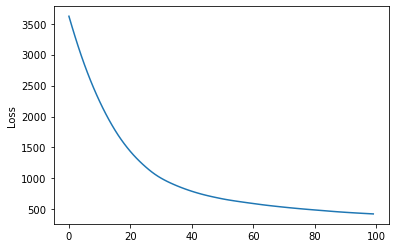

In [15]:
plt.plot(loss_collection)
plt.ylabel("Loss")

# FunctionlaAPI

In [283]:
base_model = keras.applications.vgg16.VGG16(
    weights='imagenet',
    input_shape=(32,32,3),
    include_top=False
)

vgg_layers = []
vgg_layers.append(base_model.layers[0])
for layer in base_model.layers:
    if "conv" in layer.name:
        layer.trainable = False
        vgg_layers.append(layer)

for layers in vgg_layers:
    print(f"{layers.name} ---> {layers.output_shape}")

input_31 ---> [(None, 32, 32, 3)]
block1_conv1 ---> (None, 32, 32, 64)
block1_conv2 ---> (None, 32, 32, 64)
block2_conv1 ---> (None, 16, 16, 128)
block2_conv2 ---> (None, 16, 16, 128)
block3_conv1 ---> (None, 8, 8, 256)
block3_conv2 ---> (None, 8, 8, 256)
block3_conv3 ---> (None, 8, 8, 256)
block4_conv1 ---> (None, 4, 4, 512)
block4_conv2 ---> (None, 4, 4, 512)
block4_conv3 ---> (None, 4, 4, 512)
block5_conv1 ---> (None, 2, 2, 512)
block5_conv2 ---> (None, 2, 2, 512)
block5_conv3 ---> (None, 2, 2, 512)


In [307]:
def make_Vgg_Net():
    vgg_layers = []
    for layer in base_model.layers:
        if "conv" in layer.name:
            layer.trainable = False
            vgg_layers.append(layer.output)
    model = keras.models.Model([base_model.input], [vgg_layers])
    return model

def make_Vgg_Net():
    vgg_layers = []
    for layer in base_model.layers:
        if layer.name in ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']:
            layer.trainable = False
            vgg_layers.append(layer.output)
    model = keras.models.Model([base_model.input], [vgg_layers])
    return model

In [308]:
vgg = make_Vgg_Net()

In [309]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
b_loss = keras.losses.BinaryCrossentropy()

In [310]:
content_img = get_img('input_image/dancing.jpg')
content_img = tf.reshape(content_img, [1,224,224,3])
style_img = get_img('input_image/saryan.jpg')
style_img = tf.reshape(style_img, [1,224,224,3])

target_img = tf.image.convert_image_dtype(0.5*(content_img+style_img), tf.float32)
target_img = tf.Variable([target_img])

In [311]:
def get_loss(content, style, target):
    
    content_l = vgg(content)[0]
    style_l = vgg(style)[0]
    target_l = vgg(tf.reshape(target, [1,224,224,3]))[0]
    
    loss_ct, loss_st = 0, 0
    for c,s,t in zip(content_l, style_l, target_l):
        loss_ct += tf.reduce_mean((c - t)**2)
        loss_st += tf.reduce_mean((s - t)**2)
    loss = loss_ct + loss_st
    
    return loss

In [321]:
epochs = 3000
opt = tf.optimizers.Adam(learning_rate=0.001, beta_1=0.9, epsilon=5e-2)
#loss_collection= []
for epoch in range(epochs):

    with tf.GradientTape() as tape:
        loss = get_loss(content_img, style_img, target_img)
    
    gradient = tape.gradient(loss, target_img)
    opt.apply_gradients([(gradient, target_img)])
    target_img.assign(tf.clip_by_value(target_img, clip_value_min=0.0, clip_value_max=1.0))
    
    if epoch % 100 ==0:
        tf.print(f"Loss = {round(float(loss), 3)} {epoch}")
    loss_collection.append(loss)

Loss = 29.96 0
Loss = 29.912 100
Loss = 29.839 200
Loss = 29.766 300
Loss = 29.699 400
Loss = 29.639 500
Loss = 29.588 600
Loss = 29.544 700
Loss = 29.506 800
Loss = 29.473 900
Loss = 29.444 1000
Loss = 29.419 1100
Loss = 29.396 1200
Loss = 29.377 1300
Loss = 29.359 1400
Loss = 29.344 1500
Loss = 29.33 1600
Loss = 29.317 1700
Loss = 29.306 1800
Loss = 29.295 1900
Loss = 29.286 2000
Loss = 29.277 2100
Loss = 29.268 2200
Loss = 29.261 2300
Loss = 29.254 2400
Loss = 29.247 2500
Loss = 29.241 2600
Loss = 29.235 2700
Loss = 29.23 2800
Loss = 29.225 2900


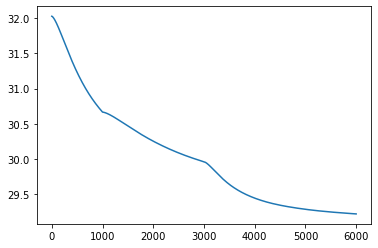

In [322]:
plt.plot(loss_collection)

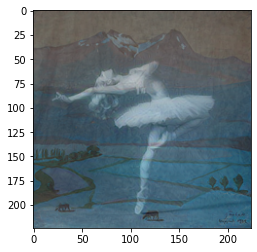

In [323]:
import PIL
tensor = target_img[0]*255
tensor = np.array(tensor, dtype=np.uint8)
if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
tensor =  PIL.Image.fromarray(tensor)
plt.imshow(cv2.cvtColor(np.array(tensor), cv2.COLOR_BGR2RGB))
plt.show()